<a href="https://colab.research.google.com/github/DerekGloudemans/segmentation-medical-images/blob/master/2D_Slice_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

#!pip uninstall torch -y
#!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html

import ipywidgets
import traitlets

#!pip3 install filterpy
#!pip3 install opencv-contrib-python

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
import torchvision.transforms.functional as FT
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import nibabel as nib



## Define Dataset for Dealing with NIfTI Files
(1) spleen
(2) right kidney
(3) left kidney
(4) gallbladder
(5) esophagus
(6) liver
(7) stomach
(8) aorta
(9) inferior vena cava
(10) portal vein and splenic vein
(11) pancreas
(12) right adrenal gland
(13) left adrenal gland

In [0]:
class Nifti_Dataset(data.Dataset):
  def __init__(self,mode = "train",dim = 2):
    """
    Save the last 0.15 proportion of files after sorting for use as validation set.
    Loads each slice of the input images as a separate image
    mode - train or val, defined in same dataset to maintain data separation
    dim - specifies dimension along which to slice image
    """

    self.mode = mode
    self.dim = dim

    data_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/img"
    label_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/label"

    # get all data and label file names
    self.data_files = []
    for file in os.listdir(data_dir):
      self.data_files.append(os.path.join(data_dir,file))
    self.data_files.sort()

    self.label_files = []
    for file in os.listdir(label_dir):
      self.label_files.append(os.path.join(label_dir,file))
    self.label_files.sort()

    # for each data_file
    self.train_data = []
    self.val_data = []

    for i in range(len(self.data_files)):
      data = nib.load(self.data_files[i])
      data = np.array(data.get_fdata())

      label = nib.load(self.label_files[i])
      label = np.array(label.get_data())

      identifier = self.data_files[i].split("_")[0]
      #print(data.shape,label.shape)
      for slice in range(0,data.shape[dim]):

        # get slices
        if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
        elif dim == 1:
          data_slice = data[:,slice,:]
          label_slice = label[:,slice,:]
        elif dim == 2:
          data_slice = data[:,:,slice]
          label_slice = label[:,:,slice]

        # define item dict to store info
        item = {
            "identifier":identifier,
            "slice":slice,
            "data":data_slice,
            "label":label_slice
                }

        # assign to either training or validation data
        if i < len(self.data_files) * 0.85:
          self.train_data.append(item)
        else:
          self.val_data.append(item)

      break # to shorten loading time

    # define some transforms for training dataset
    self.train_transforms = transforms.Compose([
          transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(p=0.15, scale=(0.4, 0.6), ratio=(0.3, 3.3), value=0, inplace=False), # big
          transforms.RandomErasing(p=0.3, scale=(0.1, 0.3), ratio=(0.3, 3.3), value=0, inplace=False), # medium
          transforms.RandomErasing(p=0.4, scale=(0.05, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),# small
          transforms.RandomErasing(p=0.35, scale=(0.05, 0.2), ratio=(0.3, 3.3), value=0, inplace=False) # small
          

        ])

  def __getitem__(self,index):
      #get relevant dictionary from self memory

      if self.mode == "train":
        item = self.train_data[index]
      else:
        item = self.val_data[index]

      x = Image.fromarray(item['data']).copy()
      y = Image.fromarray(item['label']).copy()

      # to grayscale
      x  = FT.to_grayscale(x)
      y = FT.to_grayscale(y)

      if self.mode == "train":
        # randomly flip and rotate both
        FLIP = np.random.rand()
        if FLIP > 0.5:
          x = FT.hflip(x)
          y = FT.hflip(y)

        ROTATE = np.random.rand() *60 - 30
        x  = x.rotate(ROTATE)
        y = y.rotate(ROTATE)

        # resize to 224 on shorter dimension
        x  = FT.resize(x, 224)
        y = FT.resize(y,224)

        # randomly jitter color of data and randomly erase data
        x = self.train_transforms(x)

      # to tensor
      try:
        x = FT.to_tensor(x)
      except:
        pass
      y = FT.to_tensor(y)

      return x,y

  def __len__(self):
    if self.mode == "train":
      return len(self.train_data)
    else:
      return len(self.val_data)

  def show(self,index):
    data,label = self[index]
    plt.figure()
    plt.subplot(121)
    plt.imshow(data[0],cmap = "gray")

    plt.subplot(122)
    plt.imshow(label[0],cmap = "gray")
    plt.show()
    # convert each tensor to numpy array

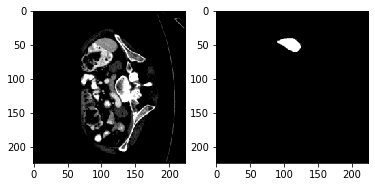

In [140]:
dataset = Nifti_Dataset(mode = "train")
idx = np.random.randint(0,len(dataset))
dataset.show(idx)

In [0]:
def show_slices(dataset,idx = 0,dim = 0,organ_id = None):
  """
  A nice utility function for plotting all of the slices along a given dimension
  idx - indexes all NIfTI images in dataset
  dim - indexes dimension of image
  organ_id - if not None, all other organs removed from label
  """
  data = nib.load(dataset.data_files[idx])
  label = nib.load(dataset.label_files[idx])

  #print(temp.header)
  data = data.get_data()
  data = np.array(data)
  label = label.get_data()
  label = np.array(label)

  for slice in range(0,data.shape[dim]):
    if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
    elif dim == 1:
      data_slice = data[:,slice,:]
      label_slice = label[:,slice,:]
    elif dim == 2:
      data_slice = data[:,:,slice]
      label_slice = label[:,:,slice]

    if organ_id is not None:
      # if a specific label is to be looked at, 0 all others
      label_slice = 1.0 - np.ceil(np.abs(label_slice-organ_id)/15.0)

    plt.figure()
    plt.subplot(121)
    plt.imshow(data_slice,cmap = "gray")

    plt.subplot(122)
    plt.imshow(label_slice,cmap = "gray")
    plt.show()

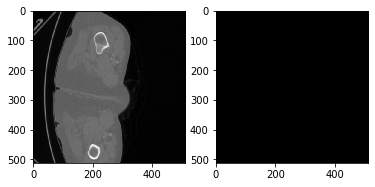

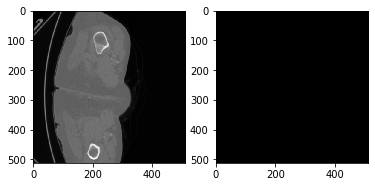

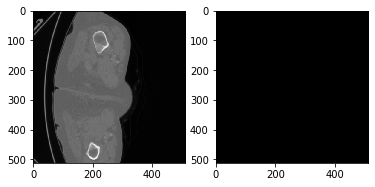

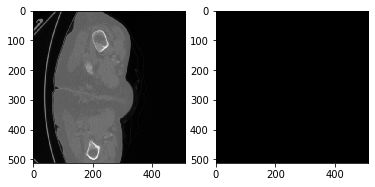

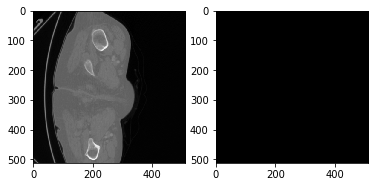

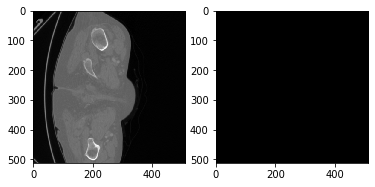

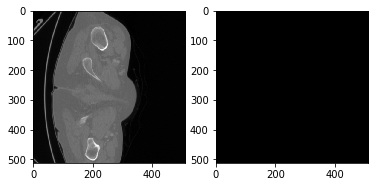

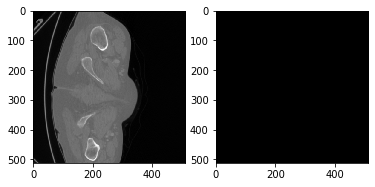

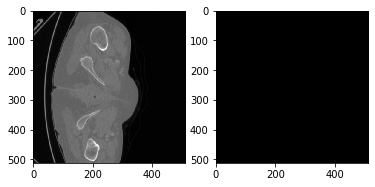

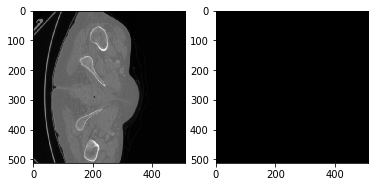

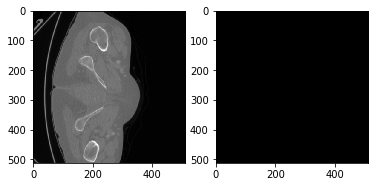

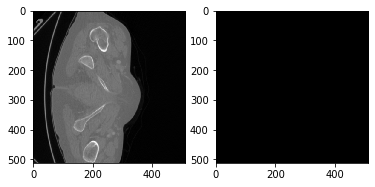

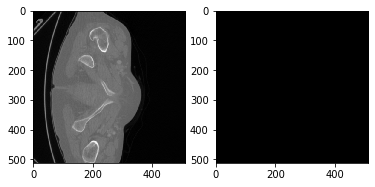

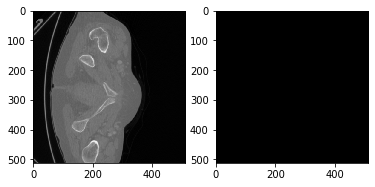

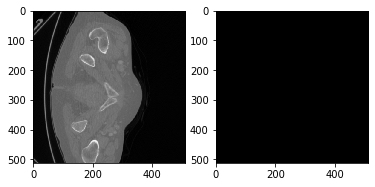

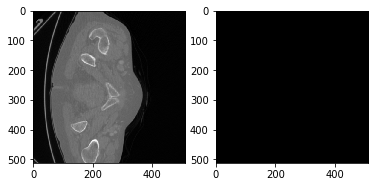

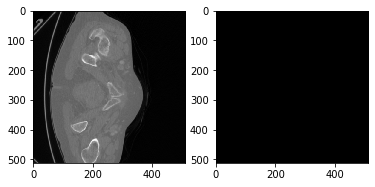

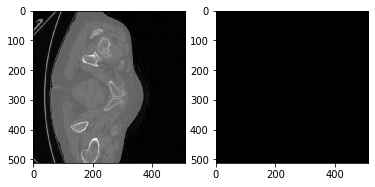

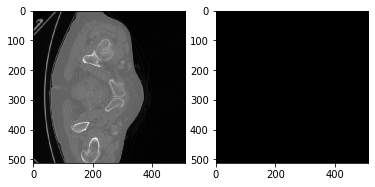

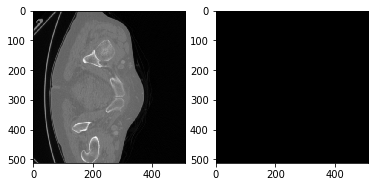

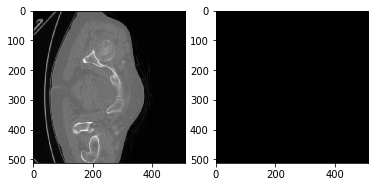

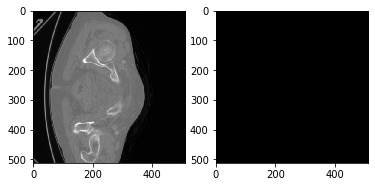

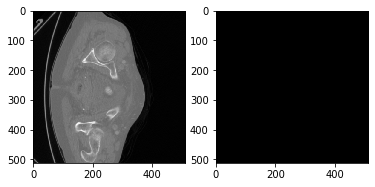

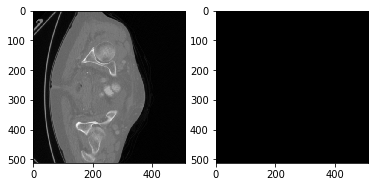

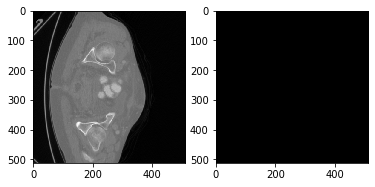

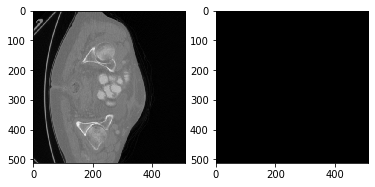

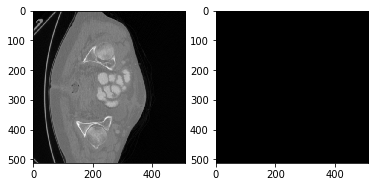

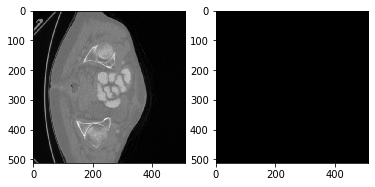

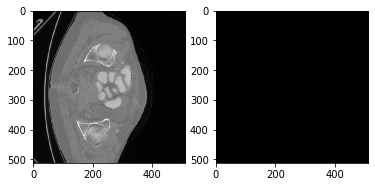

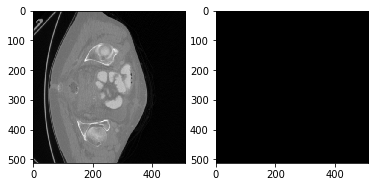

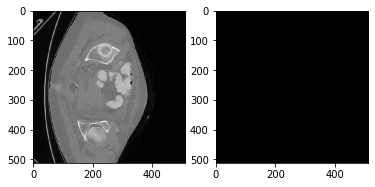

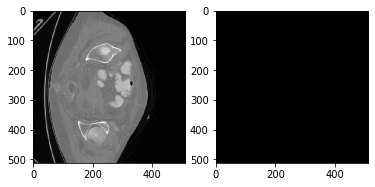

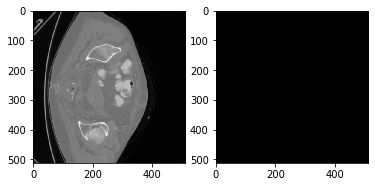

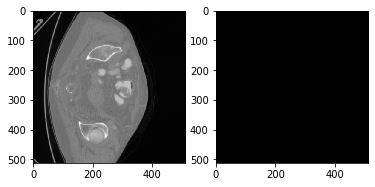

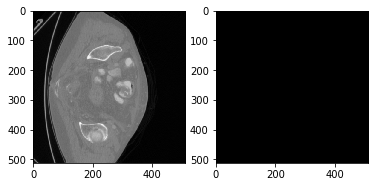

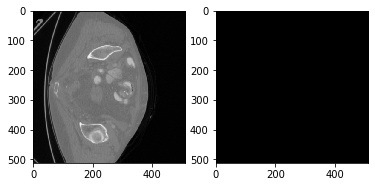

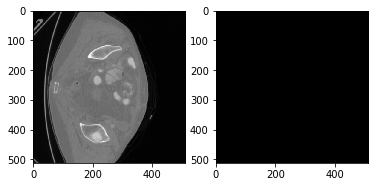

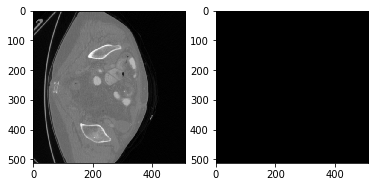

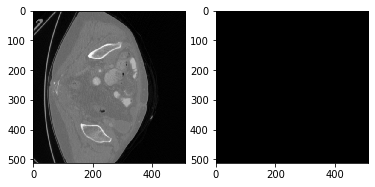

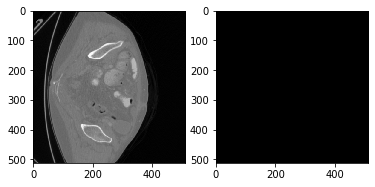

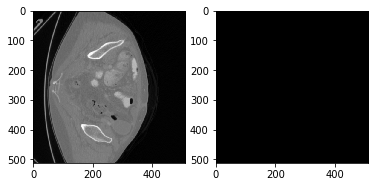

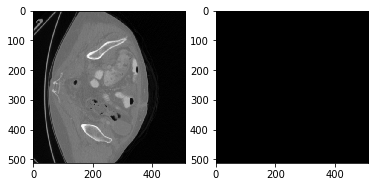

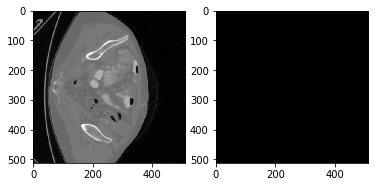

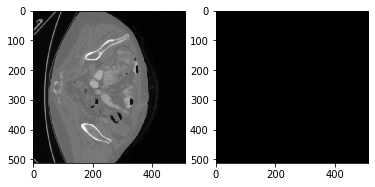

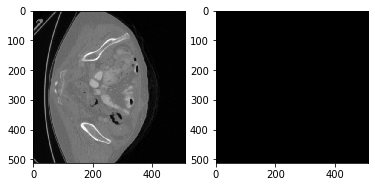

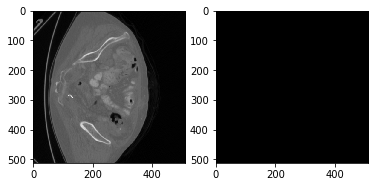

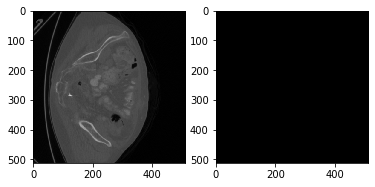

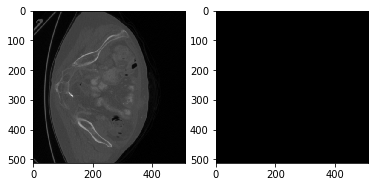

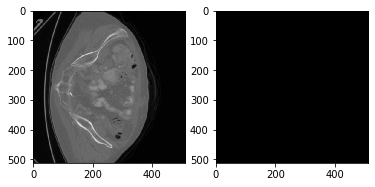

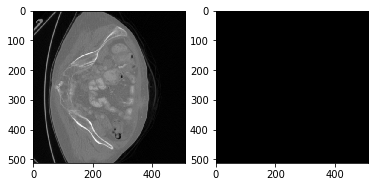

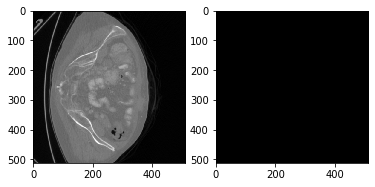

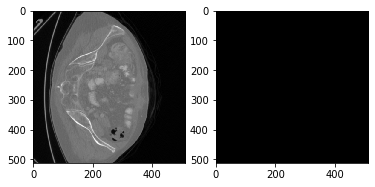

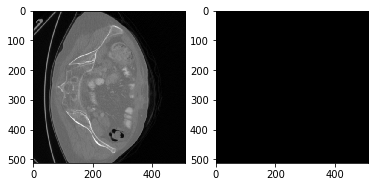

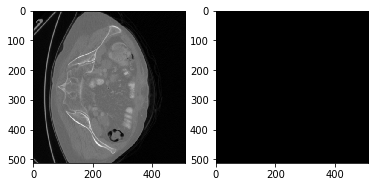

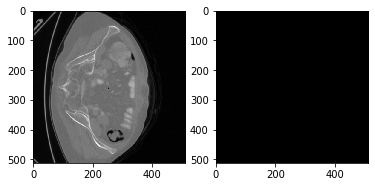

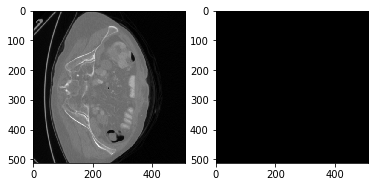

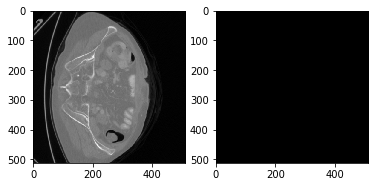

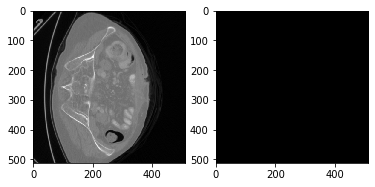

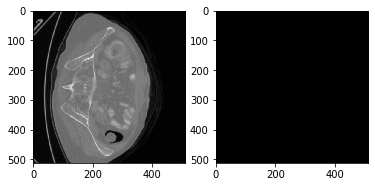

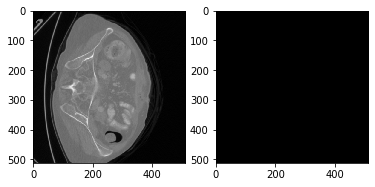

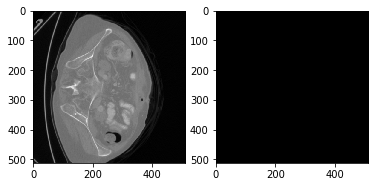

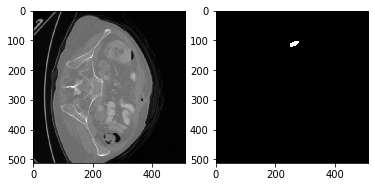

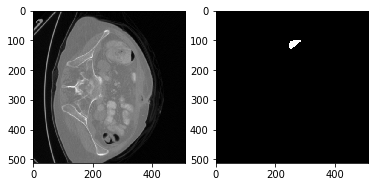

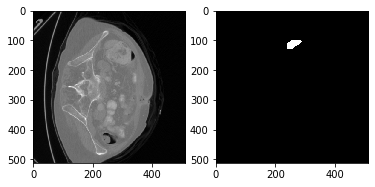

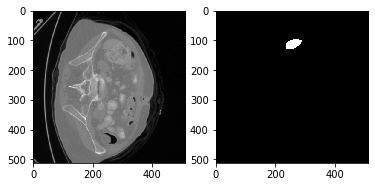

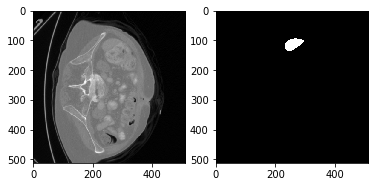

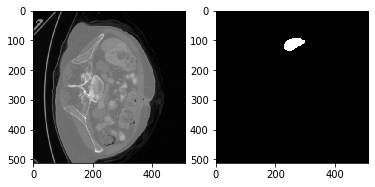

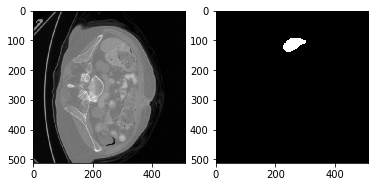

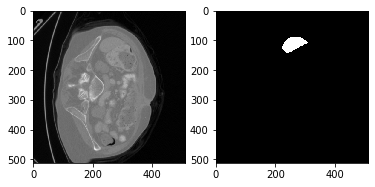

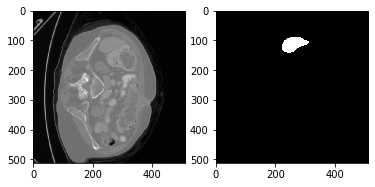

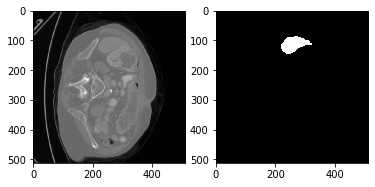

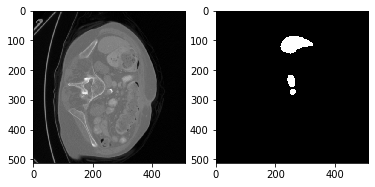

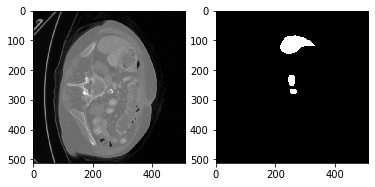

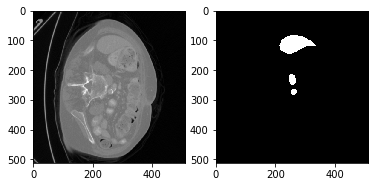

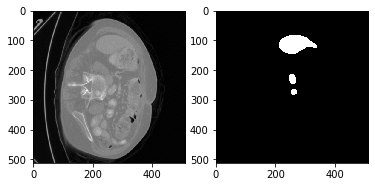

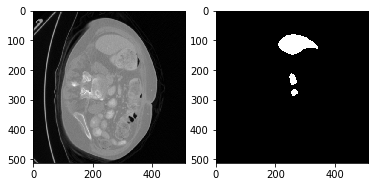

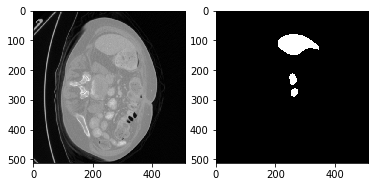

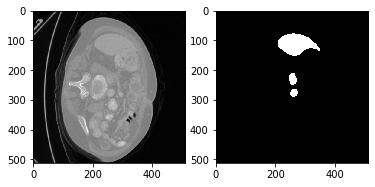

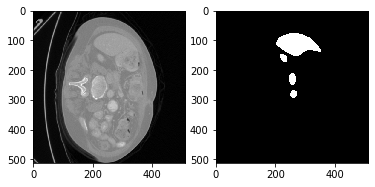

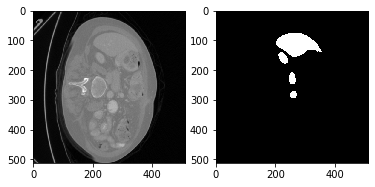

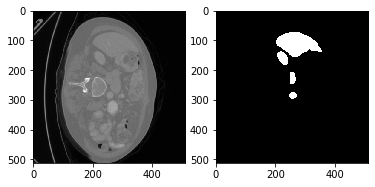

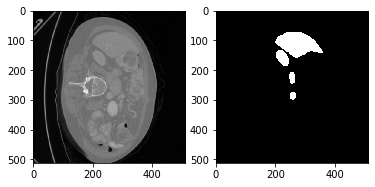

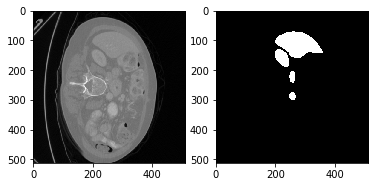

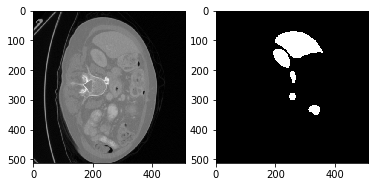

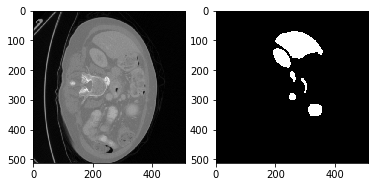

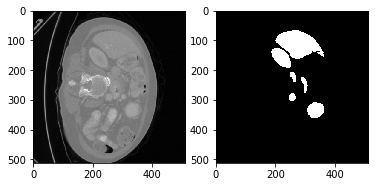

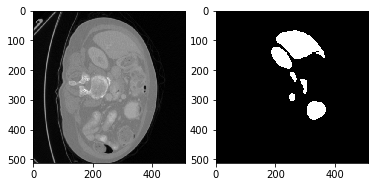

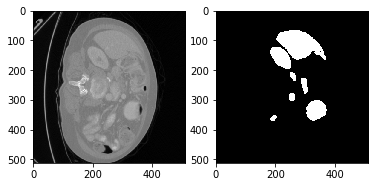

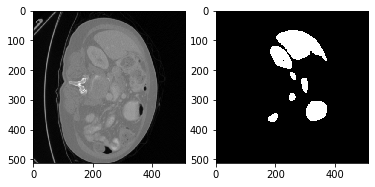

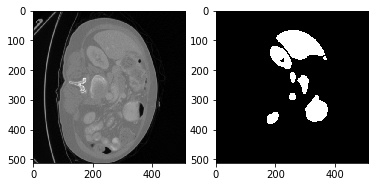

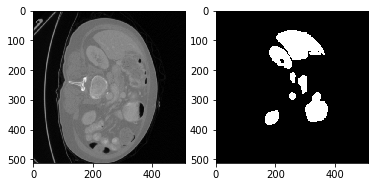

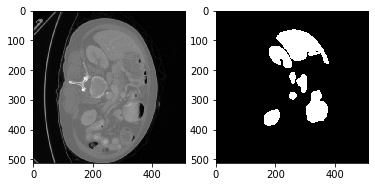

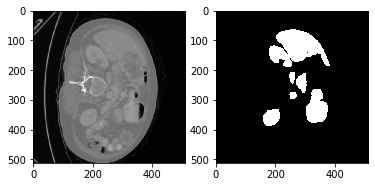

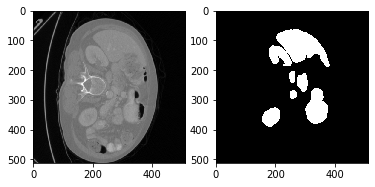

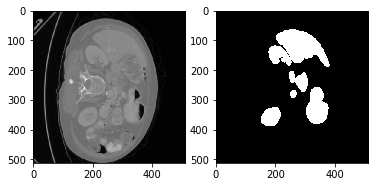

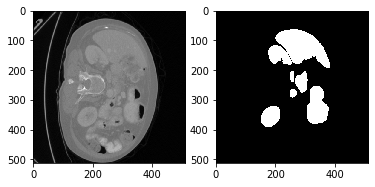

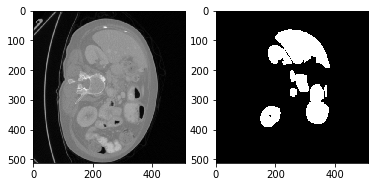

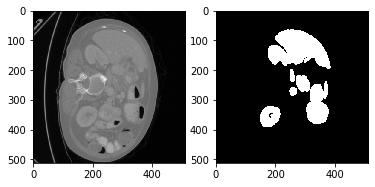

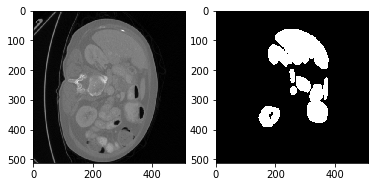

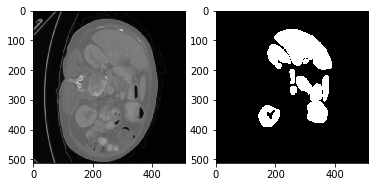

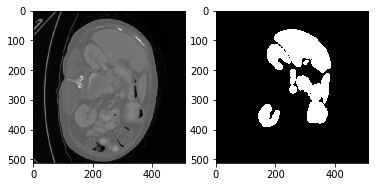

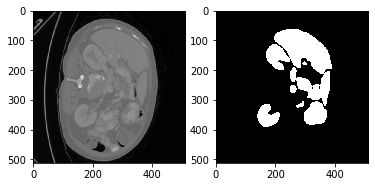

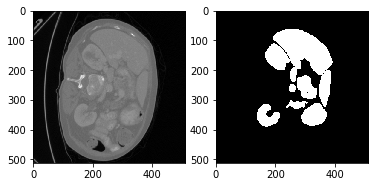

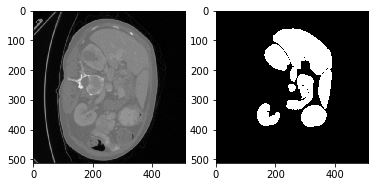

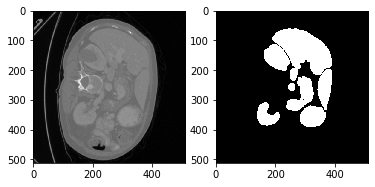

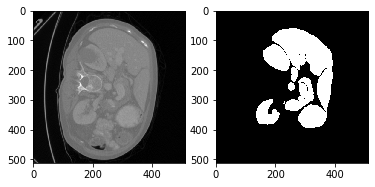

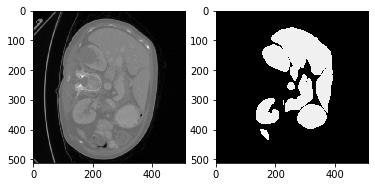

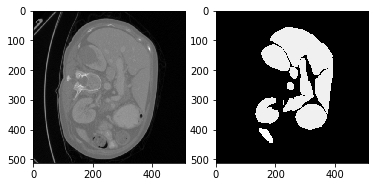

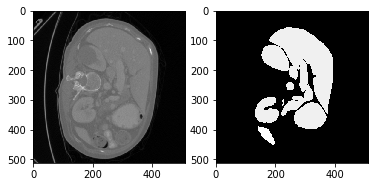

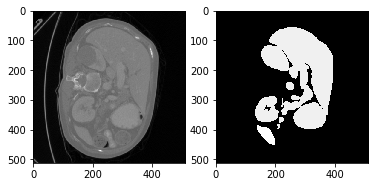

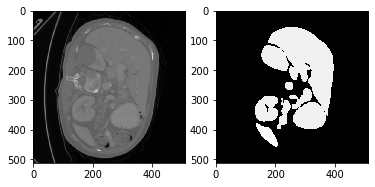

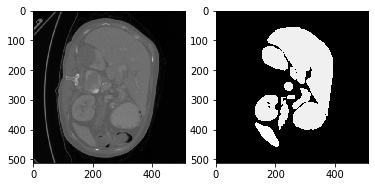

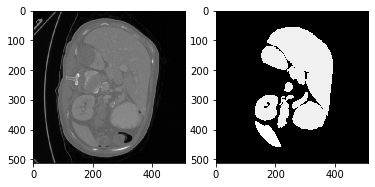

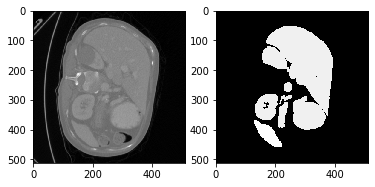

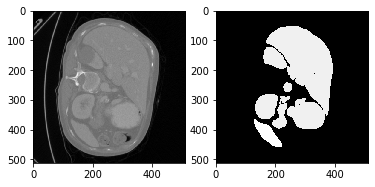

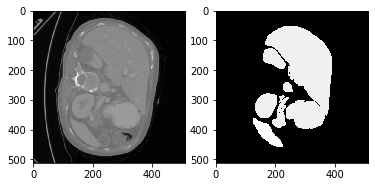

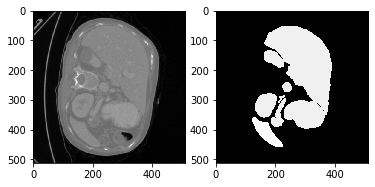

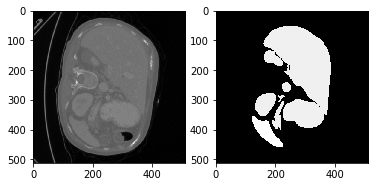

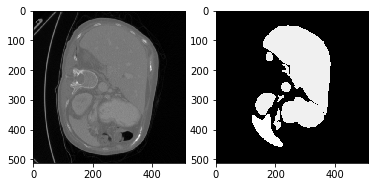

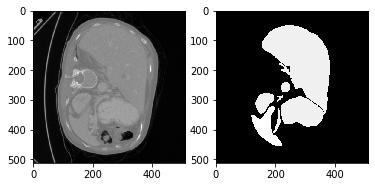

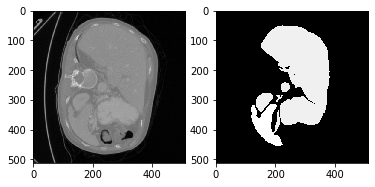

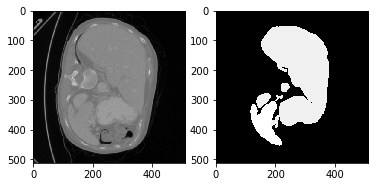

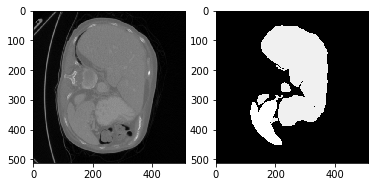

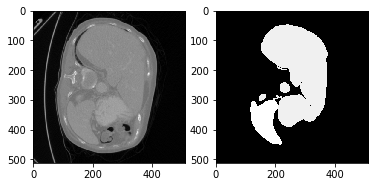

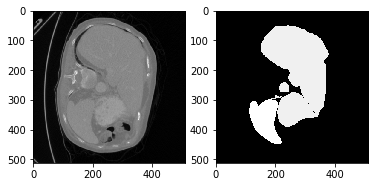

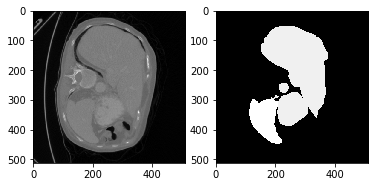

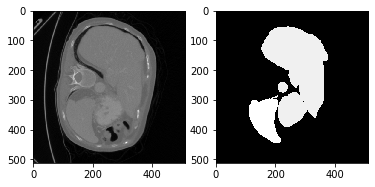

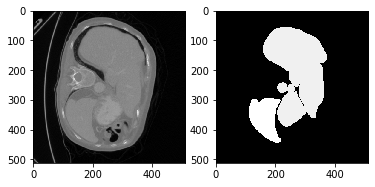

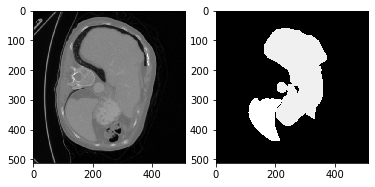

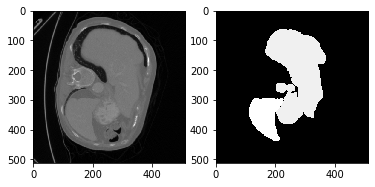

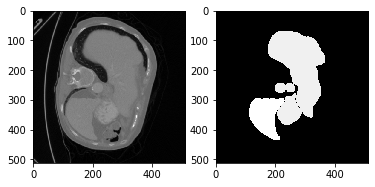

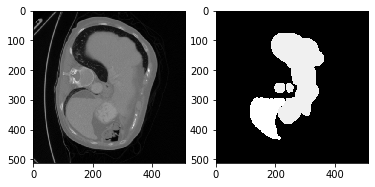

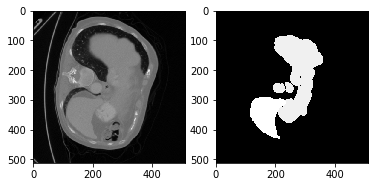

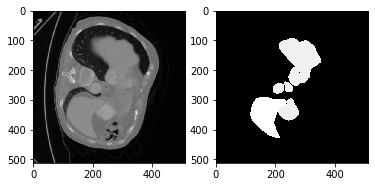

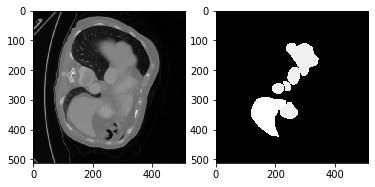

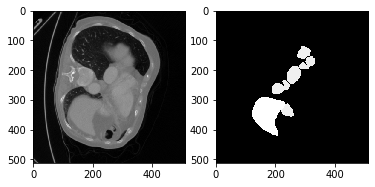

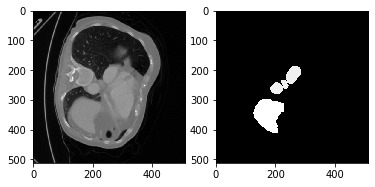

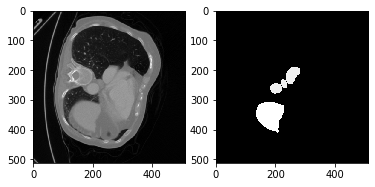

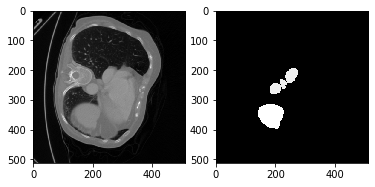

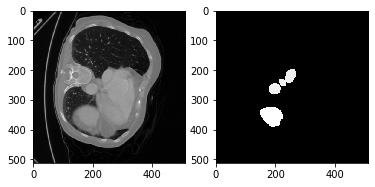

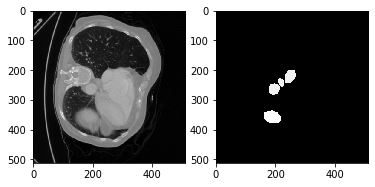

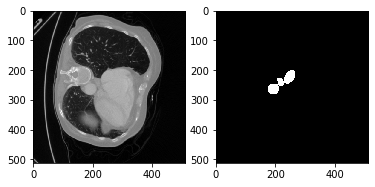

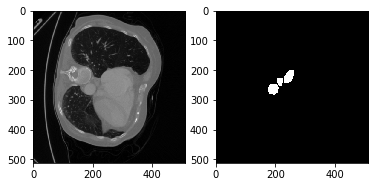

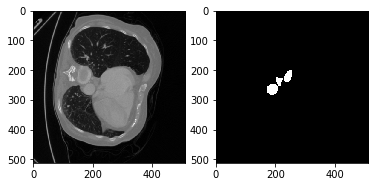

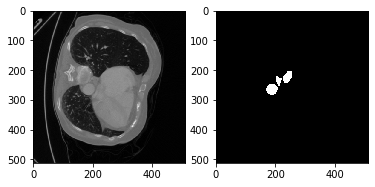

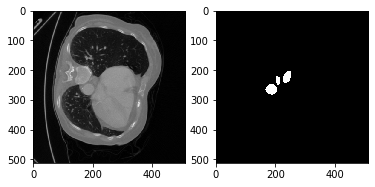

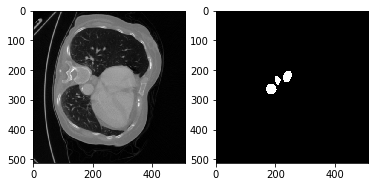

In [66]:
show_slices(dataset,0,dim = 2, organ_id = 1)